In [1]:
#TODO remove
#interesting code:
#: https://github.com/reeanne/FinalProject/blob/cef6b45060ad9646f2be4de93c226aebeadec41b/essentia-master/src/examples/python/streaming_extractor/tonaldescriptors.py
#https://github.com/LqNoob/Essentia/blob/7a70a25dd6668855b3677bd0cae0df190e319cbf/test/src/unittest/tonal/test_chordsdetection_streaming.py
#∫imple one https://github.com/mariogearth/ChordsDetectionPython/blob/b69e813bef92a361e7cad0a58bbd0f049b252914/old%20stuff/chords_test3.py

In [2]:
#Look at TODOs!!
#!pip3 install seaborn

The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed',)).History will not be written to the database.


In [3]:
import sys, os, re
import numpy as np
import pandas as pd
from collections import Counter

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
%matplotlib inline

import essentia, essentia.standard, essentia.streaming
import essentia.standard as ess
from essentia.standard import BeatTrackerMultiFeature
from essentia.standard import ChordsDetectionBeats
from essentia.streaming import *

import mir_eval
import seaborn as sns

In [4]:
'''
UTILS 
utils, inspired/copied from:
  https://github.com/seffka/ACE2017/blob/master/essentia_chord_utils.py

'''

def tuning(infile):
    hopSize = 2048
    frameSize = 8192
    loader = MonoLoader(filename=infile)
    framecutter = FrameCutter(hopSize=hopSize, frameSize=frameSize)
    windowing = Windowing(type="blackmanharris62")
    spectrum = Spectrum()
    spectralpeaks = SpectralPeaks(orderBy="frequency",
                                  magnitudeThreshold=1e-05,
                                  minFrequency=40,
                                  maxFrequency=5000,
                                  maxPeaks=10000)
    tuning = TuningFrequency()
    # use pool to store data
    pool = essentia.Pool()
    # connect algorithms together
    loader.audio >> framecutter.signal
    framecutter.frame >> windowing.frame >> spectrum.frame
    spectrum.spectrum >> spectralpeaks.spectrum
    spectralpeaks.magnitudes >> tuning.magnitudes
    spectralpeaks.frequencies >> tuning.frequencies
    tuning.tuningFrequency >> (pool, 'tonal.tuningFrequency')
    tuning.tuningCents >> (pool, 'tonal.tuningCents')
    # network is ready, run it
    print ('Processing audio file...', infile)
    essentia.run(loader)
    return np.average(pool['tonal.tuningFrequency'])

class ChordSegment :
    startTime = 0.0
    endTime = 0.0
    symbol = ''
    def __init__(self, startTime, endTime, symbol):
        self.startTime = startTime
        self.endTime = endTime
        self.symbol = symbol
    def __repr__(self):
        return str(self.startTime) + '\t' + str(self.endTime) + '\t' + self.symbol
    
def mergeSegments(chordSegments) :
    if (len(chordSegments) < 2) :
        return chordSegments
    res = []
    currentSegment = chordSegments[0]
    for segment in chordSegments[1:] :
        if (segment.symbol == currentSegment.symbol):
            currentSegment.endTime = segment.endTime
        else:
            res.append(currentSegment)
            currentSegment = segment
    res.append(currentSegment)
    return res

def convertChordLabels(chordSegments) :
    for segment in chordSegments :
        segment.symbol = re.sub('m$', ':min', segment.symbol)
    return chordSegments


def toMirexLab(startTime, endTime, onsets, symbols, strengths) :
    if (len(onsets) < len(symbols) or len(symbols) != len(strengths)) :
        raise ValueError("inappropriate lists lengths")
    if (len(onsets) == len(symbols)) :
        onsets = np.concatenate((onsets, [endTime]))
    res = []
    if (startTime < onsets[0]) :
        res.append(ChordSegment(startTime, onsets[0], 'N'))
    for i in range(len(symbols)) :
        sym = symbols[i] if strengths[i] > 0 else 'N'
        res.append(ChordSegment(onsets[i], onsets[i+1], sym))
    if (res[-1].endTime < endTime) :
        res.append(ChordSegment(res[-1].endTime, endTime, 'N'))
    return convertChordLabels(mergeSegments(res))


def processFiles(inputDir, outputDir, processFunction) :
    for file in [f for f in os.listdir(inputDir) if os.path.isfile(os.path.join(inputDir, f))] :
        name, ext = os.path.splitext(file)
        processFunction(os.path.join(inputDir, file), os.path.join(outputDir, name + '.lab'))

In [5]:
'''
Compute Chords by Frames in Essentia 
utils, inspired/copied from:
  https://github.com/seffka/ACE2017/blob/master/essentia_chord_utils.py

'''

def computeChordsByFrames(filename, outfile, frameSize=4096, hopSize=2048, tuningFrequency=440.0):

    #TODO:check pools https://essentia.upf.edu/documentation/essentia_python_tutorial.html 

    pool = essentia.Pool()
    loader = essentia.streaming.MonoLoader(filename=filename)
    
    #get the frames and compute chord detection
    fc = FrameCutter(frameSize=frameSize,
                     hopSize=hopSize,
                     silentFrames='noise')

    w = Windowing(type='blackmanharris62')
    spec = Spectrum()
    spectralpeaks = SpectralPeaks(orderBy="magnitude",
                                      magnitudeThreshold=1e-05,
                                      minFrequency=40,
                                      maxFrequency=5000,
                                      maxPeaks=10000)
    
    #TODO learn: https://essentia.upf.edu/documentation/reference/std_HPCP.html
    hpcp = HPCP(
        size=12,
        referenceFrequency = tuningFrequency,
        harmonics = 8,
        bandPreset = True,
        minFrequency = 40.0,
        maxFrequency = 5000.0,
        bandSplitFrequency = 250.0,
        weightType = "cosine",
        nonLinear = False,
        windowSize = 1.0,
        normalized='unitMax')
    
    #TODO: check parameters https://essentia.upf.edu/documentation/reference/std_ChordsDetection.html
    chords = ChordsDetection()
    chords_desc = ChordsDescriptors()


    # connect algorithms together
    loader.audio >> fc.signal
    fc.frame >> w.frame >> spec.frame
    spec.spectrum >> spectralpeaks.spectrum
    spec.spectrum >> (pool, 'spectrum.magnitude') #mine
    spectralpeaks.frequencies >> hpcp.frequencies
    spectralpeaks.magnitudes >> hpcp.magnitudes
    hpcp.hpcp >> (pool, 'chroma.hpcp')  #mine
    hpcp.hpcp >> chords.pcp
    chords.chords >> (pool, 'chords.chords')
    chords.strength >> (pool, 'chords.strength')

    essentia.run(loader)

    audio = essentia.standard.MonoLoader(filename = filename)()
    endTime = len(audio) / 44100.0
    stamps = np.arange(0, endTime, float(hopSize/44100.0))
    stamps = np.array([round(stamp,2) for stamp in stamps]) #2 decimals

    # workaround for Essentia behaviour I don't quite undestand: https://github.com/seffka/ACE2017/blob/467068d9667de43de8b8b8396e620d9e62a0d85c/essentia_chords.py
    syms = list(pool['chords.chords'][:-1])
    strengths = list(pool['chords.strength'][:-1])
    segments = toMirexLab(0.0, endTime, stamps, syms, strengths)
    with open(outfile, 'w') as content_file:
        for s in segments:
            content_file.write(str(s) + '\n')
    print("\n", outfile, " was written")

    
    spectrum= pool['spectrum.magnitude']
    chroma= pool['chroma.hpcp']
    chords= pool['chords.chords']
    chords_strength= pool['chords.strength']
    
    return spectrum, chroma, chords, chords_strength

In [6]:

def computeChordsByBeats(filename, outfile, hopSize=4096, frameSize=8192, tuningFrequency=440.0):
    
    # use pool to store data
    pool = essentia.Pool()
    # initialize algorithms we will use
    loader = MonoLoader(filename=filename)
    framecutter = FrameCutter(hopSize=hopSize, frameSize=frameSize)
    windowing = Windowing(type="blackmanharris62")
    spectrum = Spectrum()
    spectralpeaks = SpectralPeaks(orderBy="magnitude",
                                  magnitudeThreshold=1e-05,
                                  minFrequency=40,
                                  maxFrequency=5000,
                                  maxPeaks=10000)
    hpcp = HPCP(size=12,
                referenceFrequency = tuningFrequency,
                harmonics = 8,
                bandPreset = True,
                minFrequency = 40.0,
                maxFrequency = 5000.0,
                bandSplitFrequency = 500.0,
                weightType = "cosine",
                nonLinear = True,
                windowSize = 1.0)

    # connect algorithms together
    loader.audio >> framecutter.signal
    framecutter.frame >> windowing.frame >> spectrum.frame
    spectrum.spectrum >> spectralpeaks.spectrum
    spectralpeaks.magnitudes >> hpcp.magnitudes
    spectralpeaks.frequencies >> hpcp.frequencies
    hpcp.hpcp >> (pool, 'chroma.hpcp')

    essentia.run(loader)
    
    print('Loading audio file...', filename)
    audio = ess.MonoLoader(filename = filename)()
    bt = ess.BeatTrackerMultiFeature()
    beats, confidence = bt(audio)
    beats = np.array([round(beat,2) for beat in beats])
    
    #ticks = beats[::4] # TODO: should we take each 4 beats??
    print("number of beats", len(beats))

    computeChordsByBeats = ChordsDetectionBeats(hopSize=hopSize)
    chords, strengths = computeChordsByBeats(pool['chroma.hpcp'], beats)
    
    segments = toMirexLab(0.0, len(audio) / 44100.0, beats, chords, strengths)
    with open(outfile, 'w') as content_file:
        for s in segments:
            content_file.write(str(s) + '\n')
    print("\n", outfile, " was written")
    
    
    return chords, strengths, beats

In [7]:
def evaluateTriads(estimate_file, reference_file):
    '''
    expects .lab files
    performs mir_eval on triads
    return an object with '''
    (ref_intervals, ref_labels) = mir_eval.io.load_labeled_intervals(reference_file)
    (est_intervals, est_labels) = mir_eval.io.load_labeled_intervals(estimate_file)

    est_intervals, est_labels = mir_eval.util.adjust_intervals(
        est_intervals, est_labels, ref_intervals.min(),
        ref_intervals.max(), mir_eval.chord.NO_CHORD,
        mir_eval.chord.NO_CHORD)

    (intervals,
     ref_labels,
     est_labels) = mir_eval.util.merge_labeled_intervals(
        ref_intervals, ref_labels, est_intervals, est_labels)

    durations = mir_eval.util.intervals_to_durations(intervals)
    comparisons = mir_eval.chord.triads(ref_labels, est_labels)
    score = mir_eval.chord.weighted_accuracy(comparisons, durations)
    
    #create a result object and save all that might be handy
    class Object(object):
        pass
    
    result = Object()
    result.durations = durations
    result.comparisons = comparisons
    result.score = score
    result.intervals = intervals
    result.ref_labels = ref_labels
    result.est_labels = est_labels
    return result

Evaluate with mir_eval

In [10]:
#fake_test = "./estimated_chordBeat_labs/test_fake.lab"
audios_path = './audios_same_name/'
references_path = './ref_labs/'
estimated_chord_beat_path = './estimated_chordBeat_labs/'
estimated_chord_frame_path = './estimated_chordFrame_labs/'

track_name = 'maple_leaf_rag(hyman).flac'
lab_name = os.path.splitext(track_name)[0] + '.lab'

audiopath = audios_path + track_name
reference_lab = references_path + lab_name
estimated_chordBeat_lab = estimated_chord_beat_path + lab_name
estimated_chordFrame_lab = estimated_chord_frame_path + lab_name


#create lab files
song_tuning = tuning(audiopath)
computeChordsByBeats(audiopath, estimated_chordBeat_lab, tuningFrequency=song_tuning)
computeChordsByFrames(audiopath, estimated_chordFrame_lab, tuningFrequency=song_tuning)

#evaluate chord By Beat
beat_mir_eval_result = evaluateTriads(estimated_chordBeat_lab, reference_lab)

#evaluate chords By Frame
frame_mir_eval_result = evaluateTriads(estimated_chordFrame_lab, reference_lab)


Processing audio file... ./audios_same_name/maple_leaf_rag(hyman).flac
Loading audio file... ./audios_same_name/maple_leaf_rag(hyman).flac
number of beats 300

 ./estimated_chordBeat_labs/maple_leaf_rag(hyman).lab  was written

 ./estimated_chordFrame_labs/maple_leaf_rag(hyman).lab  was written


In [49]:
print("Durations: ",len(beat_mir_eval_result.durations), beat_mir_eval_result.durations)
#print("\n comparisons: \n",len(beat_mir_eval_result.comparisons),beat_mir_eval_result.comparisons)
print("\n Score by beat: ",beat_mir_eval_result.score)

#print("The number of correct detection by beat", sum(beat_mir_eval_result.comparisons))

print("Durations: ",len(frame_mir_eval_result.durations), beat_mir_eval_result.durations)
#print("\n comparisons: \n",len(frame_mir_eval_result.comparisons),beat_mir_eval_result.comparisons)
print("\n Score by frame: ",frame_mir_eval_result.score)

#print("The number of correct detection by frame",sum(frame_mir_eval_result.comparisons))

Durations:  328 [0.44 0.34 0.2  0.29 0.22 0.3  0.21 0.82 0.22 0.28 0.51 0.33 0.66 0.44
 0.07 0.45 0.05 0.46 0.04 0.47 0.04 0.99 1.01 0.04 0.98 0.04 0.46 0.48
 0.05 0.46 0.53 0.98 0.05 1.   0.04 0.47 0.46 0.04 0.45 0.51 0.5  0.5
 0.49 0.49 0.03 0.48 0.51 0.03 0.51 0.46 0.05 0.45 0.49 0.05 0.47 0.03
 0.48 0.03 0.49 0.47 0.05 1.49 0.51 0.04 0.98 0.04 0.96 0.03 0.46 0.53
 0.95 0.05 0.95 0.04 0.47 0.49 0.03 0.43 0.52 0.49 0.48 0.49 0.51 0.49
 0.51 0.03 1.89 0.04 0.45 0.48 0.47 0.49 0.03 0.47 0.48 0.97 0.04 0.46
 0.48 0.46 0.53 0.45 0.97 0.04 0.45 0.05 0.95 0.05 0.44 0.48 0.05 0.42
 0.04 0.43 0.04 0.46 0.5  0.05 0.94 0.49 0.46 0.05 0.44 0.49 0.46 0.49
 0.05 0.45 0.96 0.49 0.04 0.45 1.44 0.03 0.45 0.48 0.48 0.48 0.04 0.44
 0.96 0.05 0.44 0.06 0.92 0.04 0.93 0.04 0.42 0.05 0.46 1.47 0.45 0.04
 0.95 0.05 0.48 0.47 0.03 0.97 0.03 0.45 0.03 0.46 0.03 0.46 0.04 0.45
 0.04 1.49 0.51 0.03 0.48 0.49 0.05 0.97 0.03 0.46 0.51 0.95 0.05 0.95
 0.03 0.94 0.04 0.44 0.51 1.   1.91 0.04 0.45 0.48 0.47 0.48 0

In [12]:
QUALITIES = {
    #           1     2     3     4  5     6     7
    'maj':     [1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0],
    'min':     [1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0],
    'aug':     [1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0],
    'dim':     [1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0],
    'sus4':    [1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0],
    'sus2':    [1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0],
    '7':       [1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0],
    'maj7':    [1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1],
    'min7':    [1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0],
    'minmaj7': [1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1],
    'maj6':    [1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0],
    'min6':    [1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0],
    'dim7':    [1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0],
    'hdim7':   [1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0],
    'maj9':    [1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1],
    'min9':    [1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0],
    '9':       [1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0],
    'b9':      [1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0],
    '#9':      [1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0],
    'min11':   [1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0],
    '11':      [1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0],
    '#11':     [1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0],
    'maj13':   [1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1],
    'min13':   [1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0],
    '13':      [1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0],
    'b13':     [1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0],
    '1':       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    '5':       [1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
    '':        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}

In [13]:
#Count label pairs(the ones that's wrongly detected, and sort them
#dict_comparelabels: overall; dict_foreachchord: count mistakes for each chord
def Count_for_song(ref_labels, comparisons, est_labels):

    dict_comparelabels = dict()
    dict_foreachchord = dict()

    for i in range(0, len(ref_labels)):
        #If there is no mistake, continue
        if comparisons[i] == 1: 
            continue
        #Count overall mistakes
        temp = [ref_labels[i], est_labels[i]] #[ground truth, estimated]
        tempstr = str(temp)
        if tempstr not in dict_comparelabels:
            dict_comparelabels[tempstr] = 0
        dict_comparelabels[tempstr]+=1

        #Count for each chord
        if ref_labels[i] not in dict_foreachchord:
            dict_foreachchord[ref_labels[i]] = dict()
        if est_labels[i] not in dict_foreachchord[ref_labels[i]]:
            dict_foreachchord[ref_labels[i]][est_labels[i]] = 0
        dict_foreachchord[ref_labels[i]][est_labels[i]]+=1

    #pd_compare: count and rank mistakes, the first line is the most common mistake
    pd_compare = pd.DataFrame.from_dict(dict_comparelabels, orient = 'index')
    pd_compare.reset_index(drop = False, inplace = True)
    pd_compare.columns = ['chord pairs','count']
    pd_compare.sort_values(by=['count'], ascending=False, inplace = True)

    #pd_compareeach: count and rank mistakes for every single chord
    pd_compareeach = pd.DataFrame.from_dict(dict_foreachchord, orient = 'index')
    return pd_compareeach


Running mir_eval and analysis on Chord Detection by Beat

In [14]:
pd_compareeach_beat = Count_for_song(beat_mir_eval_result.ref_labels, beat_mir_eval_result.comparisons, beat_mir_eval_result.est_labels)

In [15]:
pd_compareeach_beat

,Eb,Ab,F:min,C#,C:min,E,C#:min,Bb,B,G,Ab:min,Eb:min,F,G:min,Bb:min,A,F#
A:dim7,3.0,6.0,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Ab,7.0,NaN,9.0,1.0,NaN,5.0,7.0,7.0,1.0,2.0,1.0,1.0,2.0,2.0,NaN,NaN,NaN
Ab:7,NaN,NaN,4.0,3.0,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Ab:min,NaN,3.0,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Bb:7,4.0,3.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,3.0,NaN,NaN
Bb:min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
D:dim7,NaN,6.0,NaN,1.0,NaN,3.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Db,2.0,11.0,6.0,NaN,NaN,2.0,3.0,1.0,NaN,NaN,NaN,1.0,NaN,NaN,7.0,NaN,NaN
Db:min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN
E,4.0,6.0,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN


In [44]:
#Making a heatmap for mistakes the algorithm has made
def makeheatmap(pd_makeheatmap):
    sns.heatmap(pd_makeheatmap, annot=True, fmt=".0f", cmap="YlGnBu")
    print("x axis is estimated chords, y axis is the ground truth")
    plt.show()
    return

x axis is estimated chords, y axis is the ground truth


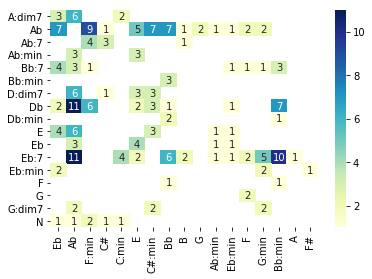

In [45]:
makeheatmap(pd_compareeach_beat)

The following function will find the most common mistakes for each chord(rank wrongly estimated chords by occurrence)

In [27]:
def find_mistakes_each_chord(pd_findmistake):
    temprow_names = []
    temprow_mistakes = []
    for rownum in range(0, len(pd_findmistake)):
        temprow = pd_findmistake.iloc[rownum]
        temprow.sort_values(ascending=False, inplace = True)
        temprow.dropna(inplace = True)
        #temprow.name is the current ground truth chord
        #temprow.index.values is the estimated chords
        #if you print temprow, it will print out the occurrence too
        temprow_names.append(temprow.name)
        temprow_mistakes.append(temprow.index.values)
        #print(temprow.name)
        #print(temprow.index.values)
    return temprow_names, temprow_mistakes


In [28]:
#Chordnames, names of chord, the 4th name corresponding to the 4th array in Mistakes_beat...
#Mistakes_beat, a list of arrays.
######TODOTODOTODO!!!!##########
#Should make a dictionary here, or turn into other OUTPUT?
chordnames_beat, mistakes_beat = find_mistakes_each_chord(pd_compareeach_beat)

In [42]:
#Showing the most common mistakes for each chord
for i in range(len(chordnames_beat)):
    print(chordnames_beat[i],mistakes_beat[i])
###TODO: What is 'N'??? 

A:dim7 ['Ab' 'Eb' 'C:min']
Ab ['F:min' 'Bb' 'C#:min' 'Eb' 'E' 'G:min' 'F' 'G' 'Eb:min' 'Ab:min' 'B' 'C#']
Ab:7 ['F:min' 'C#' 'B']
Ab:min ['E' 'Ab']
Bb:7 ['Eb' 'Bb:min' 'Ab' 'G:min' 'F' 'Eb:min' 'F:min']
Bb:min ['Bb']
D:dim7 ['Ab' 'C#:min' 'E' 'C#']
Db ['Ab' 'Bb:min' 'F:min' 'C#:min' 'E' 'Eb' 'Eb:min' 'Bb']
Db:min ['Bb' 'Bb:min']
E ['Ab' 'Eb' 'C#:min' 'Eb:min' 'Ab:min']
Eb ['E' 'Ab' 'Eb:min' 'Ab:min']
Eb:7 ['Ab' 'Bb:min' 'Bb' 'G:min' 'C:min' 'F' 'B' 'E' 'A' 'Eb:min' 'Ab:min']
Eb:min ['G:min' 'Eb' 'F#']
F ['Bb:min' 'Bb']
G ['F']
G:dim7 ['G:min' 'C#:min' 'Ab']
N ['F:min' 'C:min' 'C#' 'Ab' 'Eb']


Running mir_eval and analysis on Chord Detection by Frames

In [33]:
#Count label pairs(the ones that's wrongly detected, and sort them
pd_compareeach_frame = Count_for_song(frame_mir_eval_result.ref_labels, frame_mir_eval_result.comparisons, frame_mir_eval_result.est_labels)

In [34]:
pd_compareeach_frame

,Ab,F:min,Bb:min,C:min,Eb,C#,Eb:min,Ab:min,E,C#:min,Bb,F
A:dim7,6.0,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Ab,NaN,12.0,NaN,NaN,6.0,9.0,NaN,1.0,1.0,4.0,1.0,NaN
Ab:7,NaN,1.0,NaN,NaN,NaN,3.0,1.0,NaN,NaN,NaN,NaN,NaN
Ab:min,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN
Bb:7,2.0,NaN,6.0,NaN,7.0,1.0,3.0,NaN,NaN,NaN,NaN,NaN
Bb:min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,1.0
D:dim7,2.0,NaN,NaN,NaN,NaN,7.0,NaN,5.0,NaN,3.0,NaN,NaN
Db,11.0,6.0,4.0,NaN,2.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN
Db:min,3.0,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN
E,7.0,5.0,NaN,NaN,3.0,NaN,NaN,5.0,NaN,NaN,NaN,NaN


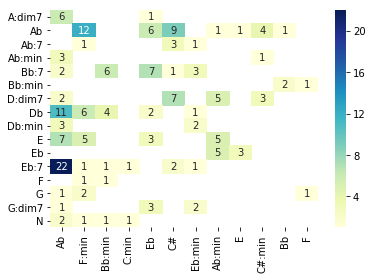

In [39]:
makeheatmap(pd_compareeach_frame)

In [36]:
chordnames_frame, mistakes_frame = find_mistakes_each_chord(pd_compareeach_frame)

In [41]:
#Showing the most common mistakes for each chord
for i in range(len(chordnames_frame)):
    print(chordnames_beat[i],mistakes_frame[i])

A:dim7 ['Ab' 'Eb']
Ab ['F:min' 'C#' 'Eb' 'C#:min' 'Bb' 'E' 'Ab:min']
Ab:7 ['C#' 'Eb:min' 'F:min']
Ab:min ['Ab' 'C#:min']
Bb:7 ['Eb' 'Bb:min' 'Eb:min' 'Ab' 'C#']
Bb:min ['Bb' 'F']
D:dim7 ['C#' 'Ab:min' 'C#:min' 'Ab']
Db ['Ab' 'F:min' 'Bb:min' 'Eb' 'Eb:min']
Db:min ['Ab' 'Eb:min']
E ['Ab' 'Ab:min' 'F:min' 'Eb']
Eb ['Ab:min' 'E']
Eb:7 ['Ab' 'C#' 'Eb:min' 'C:min' 'Bb:min' 'F:min']
Eb:min ['Bb:min' 'F:min']
F ['F:min' 'F' 'Ab']
G ['Eb' 'Eb:min' 'Ab']
G:dim7 ['Ab' 'C:min' 'Bb:min' 'F:min']


In [43]:
#scales
import json
json_path = './annotations/'

print(json_path)
print(len(os.listdir(json_path)))

keyDict = dict()
for file in os.listdir(json_path):
    file_path = os.path.join(json_path, file)
    print(file_path)
    with open(file_path, 'r') as f:
        loaded = json.load(f)
        if 'key' in loaded:
            key = loaded['key']
            print(key)
            if key not in keyDict:
                keyDict[key] = list()
            keyDict[key].append(file)



./annotations/


FileNotFoundError: [Errno 2] No such file or directory: './annotations/'

In [ ]:
keyDict